# Predict 3D Scan

In [ ]:
from cellpose import models,core

#Check if colab notebook instance has GPU access
if core.use_gpu()==False: 
    use_GPU=False
else:
    use_GPU=True


# gpu: boolean use GPU?
# model_type:  'cyto'=cytoplasm model; 'nuclei'=nucleus model; 'cyto2'=cytoplasm model with additional nucleus channel
# net_avg: loads 4 built-in networks and averages them if True, loads one network if False 
# device: if you want to use a specific GPU (e.g. torch.device('cuda:1')) (optional, default None)

model = models.Cellpose(gpu=use_GPU, model_type="cyto", net_avg=True, device=None)

In [ ]:
""" run cellpose and get masks
Parameters for model.eval()
----------
x: image batch, can be list/array of 2D/3D images
batch_size: int (optional, default 8)
channels: [0,0] for greyscale
channel_axis: int, if None, channels dimension is attempted to be automatically determined
z_axis: int if None, z dimension is attempted to be automatically determined
invert: bool, invert image pixel intensity before running network (if True, image is also normalized)
normalize: bool (optional, default True)
diameter: float (optional, default 30.) if set to None, then diameter is automatically estimated if size model is loaded
do_3D: bool (optional, default False) set to True to run 3D segmentation on 4D image input
anisotropy: float (optional, default None) for 3D segmentation, optional rescaling factor (e.g. set to 2.0 if Z is sampled half as dense as X or Y)
net_avg: bool (optional, default False) runs the 4 built-in networks and averages them if True, runs one network if False
augment: bool (optional, default False) tiles image with overlapping tiles and flips overlapped regions to augment
tile: bool (optional, default True) tiles image to ensure GPU/CPU memory usage limited (recommended)
tile_overlap: float (optional, default 0.1) fraction of overlap of tiles when computing flows
=>resample: bool (optional, default True) run dynamics at original image size (will be slower but create more accurate boundaries)
interp: bool (optional, default True) interpolate during 2D dynamics (not available in 3D) 
=>flow_threshold: float (optional, default 0.4) flow error threshold (all cells with errors below threshold are kept) (not used for 3D)
cellprob_threshold: float (optional, default 0.0) all pixels with value above threshold kept for masks, decrease to find more and larger masks
min_size: int (optional, default 15)  minimum number of pixels per mask, can turn off with -1
stitch_threshold: float (optional, default 0.0) if stitch_threshold>0.0 and not do_3D and equal image sizes, masks are stitched in 3D to return volume segmentation
rescale: float (optional, default None) if diameter is set to None, and rescale is not None, then rescale is used instead of diameter for resizing image
model_loaded: bool (optional, default False)
    internal variable for determining if model has been loaded, used in __main__.py
Returns
-------
masks: list of 2D arrays, or single 3D array (if do_3D=True)
        labelled image, where 0=no masks; 1,2,...=mask labels
flows: list of lists 2D arrays, or list of 3D arrays (if do_3D=True)
    flows[k][0] = XY flow in HSV 0-255
    flows[k][1] = XY flows at each pixel
    flows[k][2] = cell probability (if > cellprob_threshold, pixel used for dynamics)
    flows[k][3] = final pixel locations after Euler integration 
styles: list of 1D arrays of length 256, or single 1D array (if do_3D=True)
    style vector summarizing each image, also used to estimate size of objects in image
diams: list of diameters, or float (if do_3D=True)
"""      

from matplotlib import pyplot as plt
import numpy as np
import skimage

img = np.load('leaf3.npy')[:,:,:,0]
masks = np.zeros_like(img)

batch_size = 8
for i in range(img.shape[0] // batch_size):
    batch = img[i*batch_size : i*batch_size+batch_size]
    mask_batch, flows, styles, diams = model.eval(batch, batch_size=batch_size, tile=False, channels= [0,0], do_3D=True, resample=True )
    masks[i*batch_size : i*batch_size+batch_size] = mask_batch

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(masks[100])
plt.show()
# context abhängig?

In [ ]:
from skimage.measure import regionprops
def filter_regions(img, min_area=10, bg_value=0):
    regions = regionprops(img.astype(int))
    for region in regions:
        if region.area < min_area:
            img[img==region.label]=bg_value
        if region.euler_number < 1:
            img[img==region.label]=bg_value
    return img

def filter_masks(masks, min_area=10, bg_value=0):
    for i in range(masks.shape[0]):
        masks[i] = filter_regions(masks[i], min_area=10, bg_value=0)
    return masks

masks = filter_masks(masks, min_area=15, bg_value=0)

In [ ]:
count=0
for i in range(256):
    regions = regionprops(masks[i].astype(int))
    for region in regions:
        if region.area < 10:
            count+=1
print(count)

In [ ]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm

hsv = cm.get_cmap('hsv',masks.max())
random_colors = np.random.permutation(hsv (np.linspace(0, 1, int(masks.max()))))
random_colors[0,0] = 0
random_colors[0,1] = 0
random_colors[0,2] = 0
cm_random = ListedColormap (random_colors)
cm_random

In [ ]:
stack = np.zeros((256+256,256,256))
stack[::2] = img
stack[1::2] = masks

stack = stack[170:]

fig = plt.figure(figsize=(64, 64))
fig.tight_layout()
columns = 16
rows = 16
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    if i % 2 == 0:
        plt.imshow(stack[i-1], cmap=cm_random, interpolation="nearest")
    else:
        plt.imshow(stack[i-1],interpolation="nearest")
plt.savefig('cellpose2d.png')
plt.show()


# Predict 2D With GT

In [ ]:
from cellpose import models,core
import skimage
import numpy as np
from cellpose import models,core
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import numpy as np
import skimage

img1 = skimage.io.imread('data/orig_sl10.png').astype(np.float32) / 255.0#(256,256), uint8, 0-255 => float, 0-1
img2 = skimage.io.imread('data/orig_sl58.png').astype(np.float32) / 255.0
img3 = skimage.io.imread('data/orig_sl103.png').astype(np.float32) / 255.0
img4 = skimage.io.imread('data/orig_sl128.png').astype(np.float32) / 255.0
img5 = skimage.io.imread('data/orig_sl164.png').astype(np.float32) / 255.0
img6 = skimage.io.imread('data/orig_sl169.png').astype(np.float32) / 255.0
img7 = skimage.io.imread('data/orig_sl248.png').astype(np.float32) / 255.0

imgs = np.array([img1, img2, img3, img4, img5, img6, img7])

model = models.Cellpose(gpu=True, model_type="cyto", net_avg=True, device=None)
masks = np.zeros_like(imgs)

for i in range(imgs.shape[0]):
    img = imgs[i]
    mask, flows, styles, diams = model.eval(img, batch_size=1, tile=False, channels= [0,0], do_3D=False, resample=True )
    masks[i] = mask

print(imgs.shape, img.min(), img.max())
print(masks.shape)

C:\Users\admin\anaconda3\envs\cv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm

hsv = cm.get_cmap('hsv',masks.max())
random_colors = np.random.permutation(hsv (np.linspace(0, 1, int(masks.max()))))
random_colors[0,0] = 0
random_colors[0,1] = 0
random_colors[0,2] = 0
cm_random = ListedColormap (random_colors)
cm_random

stack = np.zeros((imgs.shape[0]*2,256,256))
stack[::2] = imgs
stack[1::2] = masks

fig = plt.figure(figsize=(8, 32))
fig.tight_layout()
columns = 2
rows = imgs.shape[0]
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    if i % 2 == 0:
        plt.imshow(stack[i-1], cmap=cm_random, interpolation="nearest")
    else:
        plt.imshow(stack[i-1],interpolation="nearest")
plt.show()


In [ ]:
def mask_to_rgb(mask):
    mask = mask.astype(int)
    rgb = []
    c_map = np.random.randint(0, high=255, size=(mask.max()+1,3), dtype=int)
    c_map[0]=np.array([0,0,0])
    for pixel_val in mask.ravel():
        rgb.append(c_map[pixel_val])
    rgb = np.array(rgb)
    return rgb.reshape((*mask.shape,3))

def viz_mask(img, mask, alpha):
    if img.max() <=1:
        img=img.astype(float) * 255
    img = np.stack((img,img,img), axis=-1).astype(float)
    mask = mask_to_rgb(mask).astype(float)
    viz = (1-alpha)*img + alpha*mask
    return viz.astype(int), mask.astype(int)


fig = plt.figure(figsize=(16, 64))
fig.tight_layout()
for i in range(1, imgs.shape[0] +1):
    fig.add_subplot(1, imgs.shape[0], i)
    viz, rgb_mask = viz_mask(imgs[i-1], masks[i-1], 0.3)
    plt.imshow(viz, interpolation="nearest")  
plt.show()

# Visualize

float32 uint16 float32


C:\Users\admin\AppData\Local\Temp\ipykernel_12964\874073098.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(frameon=False)


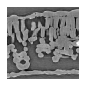

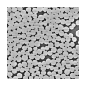

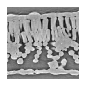

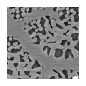

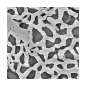

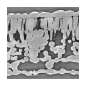

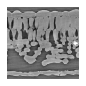

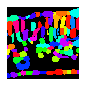

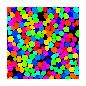

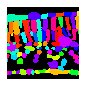

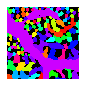

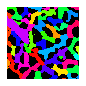

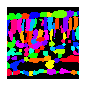

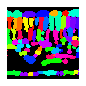

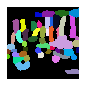

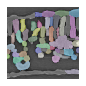

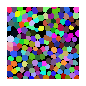

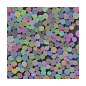

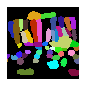

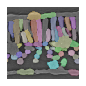

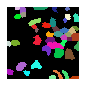

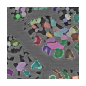

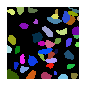

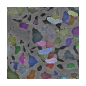

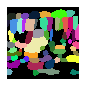

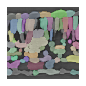

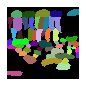

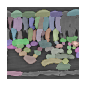

In [82]:
#for i in range(len(masks)):
#    plt.imshow(masks[i])
#    plt.axis('off')
#    plt.savefig(f'visualisation/masks_{i}.svg')
#
    
    
gt1 = skimage.io.imread('data/human_sl10.png')
gt2 = skimage.io.imread('data/human_sl58.png')
gt3 = skimage.io.imread('data/human_sl103.png')
gt4 = skimage.io.imread('data/human_sl128.png')
gt5 = skimage.io.imread('data/human_sl164.png')
gt6 = skimage.io.imread('data/human_sl169.png')
gt7 = skimage.io.imread('data/human_sl248.png')
gts = np.array([gt1,gt2,gt3,gt4,gt5,gt6,gt7])

img1 = skimage.io.imread('data/orig_sl10.png').astype(np.float32) / 255.0#(256,256), uint8, 0-255 => float, 0-1
img2 = skimage.io.imread('data/orig_sl58.png').astype(np.float32) / 255.0
img3 = skimage.io.imread('data/orig_sl103.png').astype(np.float32) / 255.0
img4 = skimage.io.imread('data/orig_sl128.png').astype(np.float32) / 255.0
img5 = skimage.io.imread('data/orig_sl164.png').astype(np.float32) / 255.0
img6 = skimage.io.imread('data/orig_sl169.png').astype(np.float32) / 255.0
img7 = skimage.io.imread('data/orig_sl248.png').astype(np.float32) / 255.0
imgs = np.array([img1, img2, img3, img4, img5, img6, img7])

print(masks.dtype, gts.dtype, imgs.dtype)

hsv = cm.get_cmap('hsv',masks.max())
random_colors = np.random.permutation(hsv (np.linspace(0, 1, int(masks.max()))))
random_colors[0,0] = 0
random_colors[0,1] = 0
random_colors[0,2] = 0
cm_random = ListedColormap (random_colors)
cm_random

for i in range(imgs.shape[0]):
    fig = plt.figure(frameon=False)
    fig.set_size_inches(1,1)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(imgs[i], aspect='auto', cmap='gray', interpolation="nearest")
    fig.savefig(f'visualisation/img_{i}.png',dpi= 256)    
    
for i in range(gts.shape[0]):
    fig = plt.figure(frameon=False)
    fig.set_size_inches(1,1)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(gts[i], aspect='auto', cmap=cm_random, interpolation="nearest")
    fig.savefig(f'visualisation/gt_{i}.png',dpi= 256) 
    
for i in range(imgs.shape[0]):
    viz, rgb_mask = viz_mask(imgs[i], masks[i], 0.3)
    
    fig = plt.figure(frameon=False)
    fig.set_size_inches(1,1)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(rgb_mask, aspect='auto', interpolation="nearest")
    fig.savefig(f'visualisation/mask_{i}.png',dpi= 256)    
    
    fig = plt.figure(frameon=False)
    fig.set_size_inches(1,1)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(viz, aspect='auto', interpolation="nearest")
    fig.savefig(f'visualisation/viz_{i}.png',dpi= 256)

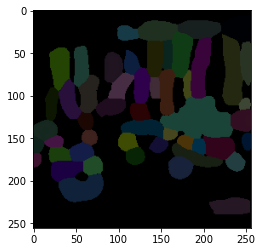

In [73]:
def mask_to_rgb(mask):
    mask = mask.astype(int)
    rgb = []
    c_map = np.random.randint(0, high=255, size=(mask.max()+1,3), dtype=int)
    c_map[0]=np.array([0,0,0])
    for pixel_val in mask.ravel():
        rgb.append(c_map[pixel_val])
    rgb = np.array(rgb)
    return rgb.reshape((*mask.shape,3))

def viz_mask(img, mask, alpha):
    if img.max() <1:
        img=img.astype(float) * 255
    img = np.stack((img,img,img), axis=-1).astype(float)
    mask = mask_to_rgb(mask).astype(float)
    viz = (1-alpha)*img + alpha*mask
    return viz.astype(int), mask.astype(int)

img=imgs[0].astype(float) * 255
img = np.stack((img,img,img), axis=-1).astype(float)
mask = mask_to_rgb(masks[0]).astype(float)
viz, _ = viz_mask(imgs[0], masks[0], 0.3)
plt.imshow(viz.astype(int))
plt.show()

# Compute mAP

In [11]:
import glob
import logging
import os
import sys

import h5py
import argparse
import numpy as np
import scipy.ndimage
from scipy.optimize import linear_sum_assignment
from skimage.segmentation import relabel_sequential


class Metrics:
    def __init__(self):
        self.metricsDict = {}
        self.metricsArray = []


    def addTable(self, name, dct=None):
        levels = name.split(".")
        if dct is None:
            dct = self.metricsDict
        if levels[0] not in dct:
            dct[levels[0]] = {}
        if len(levels) > 1:
            name = ".".join(levels[1:])
            self.addTable(name, dct[levels[0]])

    def getTable(self, name, dct=None):
        levels = name.split(".")
        if dct is None:
            dct = self.metricsDict
        if len(levels) == 1:
            return dct[levels[0]]
        else:
            name = ".".join(levels[1:])
            return self.getTable(name, dct=dct[levels[0]])

    def addMetric(self, table, name, value):
        self.metricsArray.append(value)
        tbl = self.getTable(table)
        tbl[name] = value


def maybe_crop(pred_labels, gt_labels, overlapping_inst=False):
    if overlapping_inst:
        if gt_labels.shape[1:] == pred_labels.shape[1:]:
            return pred_labels, gt_labels
        else:
            # todo: add other cases
            raise NotImplementedError("Sorry, cropping for overlapping "
                                      "instances not implemented yet!")
    else:
        if gt_labels.shape == pred_labels.shape:
            return pred_labels, gt_labels
        if gt_labels.shape[0] > pred_labels.shape[0]:
            bigger_arr = gt_labels
            smaller_arr = pred_labels
            swapped = False
        else:
            bigger_arr = pred_labels
            smaller_arr = gt_labels
            swapped = True
        begin = (np.array(bigger_arr.shape) -
                 np.array(smaller_arr.shape)) // 2
        end = np.array(bigger_arr.shape) - begin
        if len(bigger_arr.shape) == 2:
            bigger_arr = bigger_arr[begin[0]:end[0],
                                    begin[1]:end[1]]
        else:
            if (np.array(bigger_arr.shape) -
                np.array(smaller_arr.shape))[2] % 2 == 1:
                end[2] -= 1
            bigger_arr = bigger_arr[begin[0]:end[0],
                                    begin[1]:end[1],
                                    begin[2]:end[2]]
        if not swapped:
            gt_labels = bigger_arr
            pred_labels = smaller_arr
        else:
            pred_labels = bigger_arr
            gt_labels = smaller_arr

        return pred_labels, gt_labels

def evaluate_file(pred_labels, gt_labels, background=0,
                  foreground_only=False, use_linear_sum_assignment=True):
   
    
    pred_labels = np.squeeze(pred_labels)

    if gt_labels.shape[0] == 1:
        gt_labels.shape = gt_labels.shape[1:]
    gt_labels = np.squeeze(gt_labels)
    if gt_labels.ndim > pred_labels.ndim:
        gt_labels = np.max(gt_labels, axis=0)

    # pred_labels = pred_1instpch

    # heads up: should not crop channel dimensions, assuming channels first
    overlapping_inst = False
    pred_labels, gt_labels = maybe_crop(pred_labels, gt_labels,
                                        overlapping_inst)

    if foreground_only:
        pred_labels[gt_labels==0] = 0

    # relabel gt labels in case of binary mask per channel
    if overlapping_inst and np.max(gt_labels) == 1:
        for i in range(gt_labels.shape[0]):
            gt_labels[i] = gt_labels[i] * (i + 1)

    if use_linear_sum_assignment:
        return evaluate_linear_sum_assignment(gt_labels, pred_labels,
                                             overlapping_inst=False, filterSz=None,
                                             visualize=False)

    # get gt cell ids and the size of the corresponding cell
    gt_labels_list, gt_counts = np.unique(gt_labels, return_counts=True)
    gt_labels_count_dict = {}
    for (l, c) in zip(gt_labels_list, gt_counts):
        gt_labels_count_dict[l] = c

    # get pred cell ids
    pred_labels_list, pred_counts = np.unique(pred_labels,
                                              return_counts=True)
    pred_labels_count_dict = {}
    for (l, c) in zip(pred_labels_list, pred_counts):
        pred_labels_count_dict[l] = c

    # get overlapping labels
    if overlapping_inst:
        pred_tile = [1,] * pred_labels.ndim
        pred_tile[0] = gt_labels.shape[0]
        gt_tile = [1,] * gt_labels.ndim
        gt_tile[1] = pred_labels.shape[0]
        pred_tiled = np.tile(pred_labels, pred_tile).flatten()
        gt_tiled = np.tile(gt_labels, gt_tile).flatten()
        mask = np.logical_or(pred_tiled > 0, gt_tiled > 0)
        overlay = np.array([
            pred_tiled[mask],
            gt_tiled[mask]
        ])
        overlay_labels, overlay_labels_counts = np.unique(
            overlay, return_counts=True, axis=1)
        overlay_labels = np.transpose(overlay_labels)
    else:
        overlay = np.array([pred_labels.flatten(),
                            gt_labels.flatten()])
        # get overlaying cells and the size of the overlap
        overlay_labels, overlay_labels_counts = np.unique(overlay,
                                             return_counts=True, axis=1)
        overlay_labels = np.transpose(overlay_labels)

    # identify overlaying cells where more than 50% of gt cell is covered
    matchesSEG = np.asarray([c > 0.5 * float(gt_counts[gt_labels_list == v])
        for (u,v), c in zip(overlay_labels, overlay_labels_counts)],
                            dtype=np.bool)

    # get their ids
    matches_labels = overlay_labels[matchesSEG]

    # remove background
    if background is not None:
        pred_labels_list = pred_labels_list[pred_labels_list != background]
        gt_labels_list = gt_labels_list[gt_labels_list != background]

    matches_mat = np.zeros((len(pred_labels_list), len(gt_labels_list)))
    for (u, v) in matches_labels:
        if u > 0 and v > 0:
            matches_mat[np.where(pred_labels_list == u),
                        np.where(gt_labels_list == v)] = 1

    diceGT = {}
    iouGT = {}
    segGT = {}
    diceP = {}
    iouP = {}
    segP = {}
    segPrev = {}
    for (u,v), c in zip(overlay_labels, overlay_labels_counts):
        dice = 2.0 * c / (gt_labels_count_dict[v] + pred_labels_count_dict[u])
        iou = c / (gt_labels_count_dict[v] + pred_labels_count_dict[u] - c)

        if c > 0.5 * gt_labels_count_dict[v]:
            seg = iou
        else:
            seg = 0
        if c > 0.5 * pred_labels_count_dict[u]:
            seg2 = iou
        else:
            seg2 = 0

        if v not in diceGT:
            diceGT[v] = []
            iouGT[v] = []
            segGT[v] = []
        if u not in diceP:
            diceP[u] = []
            iouP[u] = []
            segP[u] = []
            segPrev[u] = []
        diceGT[v].append(dice)
        iouGT[v].append(iou)
        segGT[v].append(seg)
        diceP[u].append(dice)
        iouP[u].append(iou)
        segP[u].append(seg)
        segPrev[u].append(seg2)

    if background is not None:
        iouP.pop(background)
        iouGT.pop(background)
        diceP.pop(background)
        diceGT.pop(background)
        segP.pop(background)
        segPrev.pop(background)
        segGT.pop(background)

    dice = 0
    cnt = 0
    for (k, vs) in diceGT.items():
        vs = sorted(vs, reverse=True)
        dice += vs[0]
        cnt += 1
    diceGT = dice/max(1, cnt)

    dice = 0
    cnt = 0
    for (k, vs) in diceP.items():
        vs = sorted(vs, reverse=True)
        dice += vs[0]
        cnt += 1
    diceP = dice/max(1, cnt)

    iou = []
    instances = gt_labels.copy().astype(np.float32)
    for (k, vs) in iouGT.items():
        vs = sorted(vs, reverse=True)
        iou.append(vs[0])
        instances[instances==k] = vs[0]
    iouGT = np.array(iou)
    iouGTMn = np.mean(iouGT)

    iou = []
    iouIDs = []
    instances = pred_labels.copy().astype(np.float32)
    for (k, vs) in iouP.items():
        vs = sorted(vs, reverse=True)
        iou.append(vs[0])
        iouP[k] = vs
        iouIDs.append(k)
        instances[instances==k] = vs[0]

    iouP_2 = np.array(iou)
    iouIDs = np.array(iouIDs)
    iouPMn = np.mean(iouP_2)

    seg = 0
    cnt = 0
    for (k, vs) in segGT.items():
        vs = sorted(vs, reverse=True)
        seg += vs[0]
        cnt += 1
    segGT = seg/max(1, cnt)

    seg = 0
    cnt = 0
    for (k, vs) in segP.items():
        vs = sorted(vs, reverse=True)
        seg += vs[0]
        cnt += 1
    segP = seg/max(1, cnt)

    seg = 0
    cnt = 0
    for (k, vs) in segPrev.items():
        vs = sorted(vs, reverse=True)
        seg += vs[0]
        cnt += 1
    segPrev = seg/max(1, cnt)

    # non-split vertices num non-empty cols - num non-empty rows
    # (more than one entry in col: predicted cell with more than one
    # ground truth cell assigned)
    # (other way around not possible due to 50% rule)
    ns = np.sum(np.count_nonzero(matches_mat, axis=0)) \
            - np.sum(np.count_nonzero(matches_mat, axis=1) > 0)
    ns = int(ns)

    # false negative: empty cols
    # (no predicted cell for ground truth cell)
    fn = np.sum(np.sum(matches_mat, axis=0) == 0)
    fn = int(fn)

    # false positive: empty rows
    # (predicted cell for non existing ground truth cell)
    fp = np.sum(np.sum(matches_mat, axis=1) == 0)
    fp = int(fp)

    # true positive: row with single entry (can be 0, 1, or more)
    tpP = np.sum(np.sum(matches_mat, axis=1) == 1)
    tpP = int(tpP)

    # true positive: non-empty col (can only be 0 or 1)
    tpGT = np.sum(np.sum(matches_mat, axis=0) > 0)
    tpGT = int(tpGT)


    metrics = Metrics()
    tblNameGen = "general"
    metrics.addTable(tblNameGen)
    metrics.addMetric(tblNameGen, "Num GT", len(gt_labels_list))
    metrics.addMetric(tblNameGen, "Num Pred", len(pred_labels_list))
    metrics.addMetric(tblNameGen, "GT/Ref -> Pred mean dice", diceGT)
    metrics.addMetric(tblNameGen, "Pred -> GT/Ref mean dice", diceP)
    metrics.addMetric(tblNameGen, "GT/Ref -> Pred mean iou", iouGTMn)
    metrics.addMetric(tblNameGen, "Pred -> GT/Ref mean iou", iouPMn)
    metrics.addMetric(tblNameGen, "GT/Ref -> Pred mean seg", segGT)
    metrics.addMetric(tblNameGen, "Pred -> GT/Ref mean seg", segP)
    metrics.addMetric(tblNameGen, "Pred -> GT/Ref mean seg rev", segPrev)
    metrics.addMetric(tblNameGen, "Pred -> GT/Ref NS", ns)
    metrics.addMetric(tblNameGen, "Pred -> GT/Ref FP", fp)
    metrics.addMetric(tblNameGen, "Pred -> GT/Ref TP", tpP)
    metrics.addMetric(tblNameGen, "GT/Ref -> Pred FN", fn)
    metrics.addMetric(tblNameGen, "GT/Ref -> Pred TP", tpGT)

    ths = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    aps = []
    metrics.addTable("confusion_matrix")
    for th in ths:
        tblname = "confusion_matrix.th_"+str(th).replace(".","_")
        metrics.addTable(tblname)
        apTP = 0
        for pID in np.nonzero(iouP_2 > th)[0]:
            if len(iouP[iouIDs[pID]]) == 0:
                pass
            elif len(iouP[iouIDs[pID]]) == 1:
                apTP += 1
            elif len(iouP[iouIDs[pID]]) > 1 and iouP[iouIDs[pID]][1] < th:
                apTP += 1
        metrics.addMetric(tblname, "AP_TP", apTP)
        apTP = np.count_nonzero(iouP_2[iouP_2>th])
        apFP = np.count_nonzero(iouP_2[iouP_2<=th])
        apFN = np.count_nonzero(iouGT[iouGT<=th])
        metrics.addMetric(tblname, "AP_TP", apTP)
        metrics.addMetric(tblname, "AP_FP", apFP)
        metrics.addMetric(tblname, "AP_FN", apFN)
        ap = 1.*(apTP) / max(1, apTP + apFN + apFP)
        aps.append(ap)
        metrics.addMetric(tblname, "AP", ap)
        precision = 1.*(apTP) / max(1, len(pred_labels_list))
        metrics.addMetric(tblname, "precision", precision)
        recall = 1.*(apTP) / max(1, len(gt_labels_list))
        metrics.addMetric(tblname, "recall", recall)
        if (precision + recall) > 0:
            fscore = (2. * precision * recall) / max(1, precision + recall)
        else:
            fscore = 0.0
        metrics.addMetric(tblname, 'fscore', fscore)

    avAP = np.mean(aps)
    metrics.addMetric("confusion_matrix", "avAP", avAP)

    return metrics.metricsDict


def evaluate_linear_sum_assignment(gt_labels, pred_labels,
                                   overlapping_inst=False, filterSz=None,
                                   visualize=False):
    if filterSz is not None:
        ls, cs = np.unique(pred_labels, return_counts=True)
        pred_labels2 = np.copy(pred_labels)
        for l, c in zip(ls, cs):
            if c < filterSz:
                pred_labels[pred_labels==l] = 0
            # else:
            #     pred_labels2[pred_labels==l] = 0
        # with h5py.File(outFn + ".hdf", 'w') as f:
        #     f.create_dataset(
        #         'volumes/small_inst',
        #         data=pred_labels2,
        #         compression='gzip')
    pred_labels_rel, _, _ = relabel_sequential(pred_labels)
    gt_labels_rel, _, _ = relabel_sequential(gt_labels)

    if overlapping_inst:
        pred_tile = [1, ] * pred_labels_rel.ndim
        pred_tile[0] = gt_labels_rel.shape[0]
        gt_tile = [1, ] * gt_labels_rel.ndim
        gt_tile[1] = pred_labels_rel.shape[0]
        pred_tiled = np.tile(pred_labels_rel, pred_tile).flatten()
        gt_tiled = np.tile(gt_labels_rel, gt_tile).flatten()
        mask = np.logical_or(pred_tiled > 0, gt_tiled > 0)
        overlay = np.array([
            pred_tiled[mask],
            gt_tiled[mask]
        ])
        overlay_labels, overlay_labels_counts = np.unique(
            overlay, return_counts=True, axis=1)
        overlay_labels = np.transpose(overlay_labels)
    else:
        overlay = np.array([pred_labels_rel.flatten(),
                            gt_labels_rel.flatten()])
        # get overlaying cells and the size of the overlap
        overlay_labels, overlay_labels_counts = np.unique(
            overlay, return_counts=True, axis=1)
        overlay_labels = np.transpose(overlay_labels)

    # get gt cell ids and the size of the corresponding cell
    gt_labels_list, gt_counts = np.unique(gt_labels_rel, return_counts=True)
    gt_labels_count_dict = {}
    for (l,c) in zip(gt_labels_list, gt_counts):
        gt_labels_count_dict[l] = c

    # get pred cell ids
    pred_labels_list, pred_counts = np.unique(pred_labels_rel,
                                              return_counts=True)

    pred_labels_count_dict = {}
    for (l,c) in zip(pred_labels_list, pred_counts):
        pred_labels_count_dict[l] = c

    num_pred_labels = int(np.max(pred_labels_rel))
    num_gt_labels = int(np.max(gt_labels_rel))
    num_matches = min(num_gt_labels, num_pred_labels)
    iouMat = np.zeros((num_gt_labels+1, num_pred_labels+1),
                      dtype=np.float32)
    recallMat = np.zeros((num_gt_labels+1, num_pred_labels+1),
                         dtype=np.float32)
    precMat = np.zeros((num_gt_labels+1, num_pred_labels+1),
                       dtype=np.float32)
    fscoreMat = np.zeros((num_gt_labels+1, num_pred_labels+1),
                         dtype=np.float32)

    for (u,v), c in zip(overlay_labels, overlay_labels_counts):
        iou = c / (gt_labels_count_dict[v] + pred_labels_count_dict[u] - c)

        iouMat[v, u] = iou
        recallMat[v, u] = c / gt_labels_count_dict[v]
        precMat[v, u] = c / pred_labels_count_dict[u]
        fscoreMat[v, u] = 2 * (precMat[v, u] * recallMat[v, u]) / \
                              (precMat[v, u] + recallMat[v, u])
    iouMat = iouMat[1:, 1:]
    recallMat = recallMat[1:, 1:]
    precMat = precMat[1:, 1:]
    fscoreMat = fscoreMat[1:, 1:]

    metrics = Metrics()
    tblNameGen = "general"
    metrics.addTable(tblNameGen)
    metrics.addMetric(tblNameGen, "Num GT", num_gt_labels)
    metrics.addMetric(tblNameGen, "Num Pred", num_pred_labels)

    ths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    aps = []
    metrics.addTable("confusion_matrix")
    for th in ths:
        tblname = "confusion_matrix.th_"+str(th).replace(".", "_")
        metrics.addTable(tblname)
        fscore = 0
        if num_matches > 0 and np.max(iouMat) > th:
            costs = -(iouMat >= th).astype(float) - iouMat / (2*num_matches)
            gt_ind, pred_ind = linear_sum_assignment(costs)
            assert num_matches == len(gt_ind) == len(pred_ind)
            match_ok = iouMat[gt_ind, pred_ind] >= th
            tp = np.count_nonzero(match_ok)
            fscore_cnt = 0
            for idx, match in enumerate(match_ok):
                if match:
                    fscore = fscoreMat[gt_ind[idx], pred_ind[idx]]
                    if fscore >= 0.8:
                        fscore_cnt += 1
        else:
            tp = 0
            fscore_cnt = 0
        if visualize and tp > 0 and th == 0.5:
            vis_tp = np.zeros_like(gt_labels_rel, dtype=np.float32)
            vis_fp = np.zeros_like(gt_labels_rel, dtype=np.float32)
            vis_fn = np.zeros_like(gt_labels_rel, dtype=np.float32)
            vis_tp_seg = np.zeros_like(gt_labels_rel, dtype=np.float32)
            vis_tp_seg2 = np.zeros_like(gt_labels_rel, dtype=np.float32)
            vis_fp_seg = np.zeros_like(gt_labels_rel, dtype=np.float32)
            vis_fn_seg = np.zeros_like(gt_labels_rel, dtype=np.float32)
            if len(gt_labels_rel.shape) == 3:
                vis_fp_seg_bnd = np.zeros_like(gt_labels_rel, dtype=np.float32)
                vis_fn_seg_bnd = np.zeros_like(gt_labels_rel, dtype=np.float32)

            cntrs_gt = scipy.ndimage.measurements.center_of_mass(
                gt_labels_rel > 0,
                gt_labels_rel, sorted(list(np.unique(gt_labels_rel)))[1:])
            cntrs_pred = scipy.ndimage.measurements.center_of_mass(
                pred_labels_rel > 0,
                pred_labels_rel, sorted(list(np.unique(pred_labels_rel)))[1:])
            sz = 1
            for gti, pi, in zip(gt_ind, pred_ind):
                if iouMat[gti, pi] < th:
                    vis_fn_seg[gt_labels_rel == gti+1] = 1
                    if len(gt_labels_rel.shape) == 3:
                        set_boundary(gt_labels_rel, gti+1,
                                     vis_fn_seg_bnd)
                    vis_fp_seg[pred_labels_rel == pi+1] = 1
                    if len(gt_labels_rel.shape) == 3:
                        set_boundary(pred_labels_rel, pi+1,
                                     vis_fp_seg_bnd)
                    cntr = cntrs_gt[gti]
                    if len(gt_labels_rel.shape) == 3:
                        vis_fn[int(cntr[0]), int(cntr[1]), int(cntr[2])] = 1
                    else:
                        vis_fn[int(cntr[0]), int(cntr[1])] = 1
                    cntr = cntrs_pred[pi]
                    if len(gt_labels_rel.shape) == 3:
                        vis_fp[int(cntr[0]), int(cntr[1]), int(cntr[2])] = 1
                    else:
                        vis_fp[int(cntr[0]), int(cntr[1])] = 1
                else:
                    vis_tp_seg[gt_labels_rel == gti+1] = 1
                    cntr = cntrs_gt[gti]
                    if len(gt_labels_rel.shape) == 3:
                        vis_tp[int(cntr[0]), int(cntr[1]), int(cntr[2])] = 1
                    else:
                        vis_tp[int(cntr[0]), int(cntr[1])] = 1
                    vis_tp_seg2[pred_labels_rel == pi+1] = 1
            vis_tp = scipy.ndimage.gaussian_filter(vis_tp, sz, truncate=sz)
            for gti in range(num_gt_labels):
                if gti in gt_ind:
                    continue
                vis_fn_seg[gt_labels_rel == gti+1] = 1
                if len(gt_labels_rel.shape) == 3:
                    set_boundary(gt_labels_rel, gti+1,
                                 vis_fn_seg_bnd)
                cntr = cntrs_gt[gti]
                if len(gt_labels_rel.shape) == 3:
                    vis_fn[int(cntr[0]), int(cntr[1]), int(cntr[2])] = 1
                else:
                    vis_fn[int(cntr[0]), int(cntr[1])] = 1
            vis_fn = scipy.ndimage.gaussian_filter(vis_fn, sz, truncate=sz)
            for pi in range(num_pred_labels):
                if pi in pred_ind:
                    continue
                vis_fp_seg[pred_labels_rel == pi+1] = 1
                if len(gt_labels_rel.shape) == 3:
                    set_boundary(pred_labels_rel, pi+1,
                                 vis_fp_seg_bnd)
                cntr = cntrs_pred[pi]
                if len(gt_labels_rel.shape) == 3:
                    vis_fp[int(cntr[0]), int(cntr[1]), int(cntr[2])] = 1
                else:
                    vis_fp[int(cntr[0]), int(cntr[1])] = 1
            vis_fp = scipy.ndimage.gaussian_filter(vis_fp, sz, truncate=sz)
            vis_tp = vis_tp/np.max(vis_tp)
            vis_fp = vis_fp/np.max(vis_fp)
            vis_fn = vis_fn/np.max(vis_fn)
           
        metrics.addMetric(tblname, "Fscore_cnt", fscore_cnt)
        fp = num_pred_labels - tp
        fn = num_gt_labels - tp
        metrics.addMetric(tblname, "AP_TP", tp)
        metrics.addMetric(tblname, "AP_FP", fp)
        metrics.addMetric(tblname, "AP_FN", fn)
        ap = tp / max(1, tp + fn + fp)
        aps.append(ap)
        metrics.addMetric(tblname, "AP", ap)
        precision = tp / max(1, tp + fp)
        metrics.addMetric(tblname, "precision", precision)
        recall = tp / max(1, tp + fn)
        metrics.addMetric(tblname, "recall", recall)
        if (precision + recall) > 0:
            fscore = (2. * precision * recall) / max(1, precision + recall)
        else:
            fscore = 0.0
        metrics.addMetric(tblname, 'fscore', fscore)

    avAP19 = np.mean(aps)
    avAP59 = np.mean(aps[4:])
    metrics.addMetric("confusion_matrix", "avAP", avAP19)
    metrics.addMetric("confusion_matrix", "avAP59", avAP59)
    metrics.addMetric("confusion_matrix", "avAP19", avAP19)

    return metrics.metricsDict


def set_boundary(labels_rel, label, target):
    coords_z, coords_y, coords_x = np.nonzero(labels_rel == label)
    coords = {}
    for z,y,x in zip(coords_z, coords_y, coords_x):
        coords.setdefault(z, []).append((z, y, x))
    max_z = -1
    max_z_len = -1
    for z, v in coords.items():
        if len(v) > max_z_len:
            max_z_len = len(v)
            max_z = z
    tmp = np.zeros_like(labels_rel[max_z], dtype=np.float32)
    tmp = labels_rel[max_z]==label
    struct = scipy.ndimage.generate_binary_structure(2, 2)
    eroded_tmp = scipy.ndimage.binary_erosion(
        tmp,
        iterations=1,
        structure=struct,
        border_value=1)
    bnd = np.logical_xor(tmp, eroded_tmp)
    target[max_z][bnd] = 1

In [41]:
from skimage import io
gt_labels = io.imread('data/human_sl248.png').astype(np.uint32)
pred_labels =  masks[6].astype(np.uint32)

# human_sl10 = masks[0]
# human_sl58 = masks[1]
# human_sl103 = masks[2]
# human_sl128 = masks[3]
# human_sl164 = masks[4]
# human_sl169 = masks[5]
# human_sl248 = masks[6]

print(gt_labels.min(), gt_labels.max(), gt_labels.shape, gt_labels.dtype)
print(pred_labels.min(), pred_labels.max(), pred_labels.shape, pred_labels.dtype)

metr = evaluate_file(pred_labels, gt_labels, background=0,
                  foreground_only=False, use_linear_sum_assignment=True)

mAP = metr['confusion_matrix']['avAP']
print(mAP)

0 255 (256, 256) uint32
0 56 (256, 256) uint32
0.2649163734842796
